# Custom NER training on pre-trained BERT-base-cased language model

In [1]:
# Installing the packages
%%capture
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [2]:
#import necessary libraries

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from collections import Counter

# JSON files to SPACY format

Processing dataset of text documents with associated entity annotations. It uses spaCy to create a blank English language model and then converts each text into a spaCy document, while also aligning the entity annotations with the text.

In [3]:
def make_spacy_dataset(data, db = []):

    nlp = spacy.blank('en') ## Create a blank English language model using spaCy
    failed_record = [] ## Initialize a list to store failed records that couldn't be processed

    ## If no existing DocBin is provided, create a new one
    if not db:
        db = DocBin()

    # Loop through each text and its annotations in the data
    for text, annot in tqdm(data):
        doc = nlp.make_doc(text) # # Convert the raw text into a spaCy document
        ents = [] # Initialize an empty list to store the extracted entities

        # Loop through each entity annotation in the current text
        for start, end, label in annot['entities']:
           # Create a spaCy span object for each entity and try to align it with the raw text
            span = doc.char_span(start, end, label = label, alignment_mode = 'contract')

            # Check if the span was successfully created, and append it to the list of entities
            if span is None:
              pass
              #print(f'empty entity, {text}, {annot["entities"]}')
            else:
              ents.append(span)

        try:
            doc.ents = ents # Try to set the entities of the document to the extracted entities
        except:
            failed_record.append((text, annot))

        # Add the processed document to the DocBin
        db.add(doc)
    return db, failed_record  # Return the populated DocBin and the list of failed records

In [24]:
##path to annotated resume data and list of it

tagged_data = '/content/drive/MyDrive/Dissertation/tagged_data'
list_tagged_files = os.listdir(tagged_data)

In [ ]:
len(list_tagged_files)

179

In [ ]:
##path for storing resumes in spacy format

output_tagged_spacy_form ='/content/drive/MyDrive/Dissertation/output_tagged_spacy_form'

100%|██████████| 179/179 [00:00<00:00, 1031.23it/s]


Label 'JOB TITLE': 205
Label 'SKILL': 5508
Label 'EXPERIENCE': 885
Label 'EDUCATION': 827


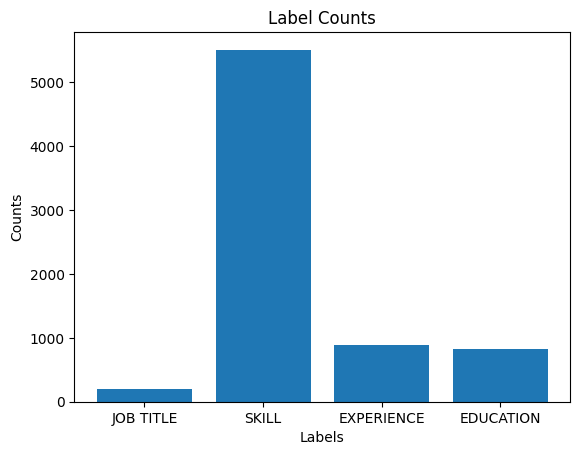

In [ ]:
# Create an empty dictionary to store counts for each label
label_counts = Counter()

for i in tqdm(range(len(list_tagged_files))):
  file_path = os.path.join(tagged_data,list_tagged_files[i])
  # print(file_path)
  with open(file_path,'r') as f:
    data = json.load(f)
  for annot in data['annotations']:
    for start, end, label in annot[1]['entities']:
      label_counts[label] += 1

# Display the counts for each label
for label, count in label_counts.items():
    print(f"Label '{label}': {count}")

# Extract labels and counts for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the bar chart
plt.bar(labels, counts)

# Set plot title and axis labels
plt.title("Label Counts")
plt.xlabel("Labels")
plt.ylabel("Counts")

# Show the plot
plt.show()


In [ ]:
# Converting json annotated files to spacy format
for i in tqdm(range(len(list_tagged_files))):
  file_path = os.path.join(tagged_data,list_tagged_files[i])
  # print(file_path)
  with open(file_path,'r') as f:
    data = json.load(f)

  saving_path = os.path.join(output_tagged_spacy_form,list_tagged_files[i][:-5]+'.spacy')
  a,b = make_spacy_dataset(data['annotations'])
  a.to_disk(saving_path)

100%|██████████| 179/179 [00:32<00:00,  5.48it/s]


# Train-validation split

In [ ]:
# Define the source directory where your samples are located
source_directory = "/content/drive/MyDrive/Dissertation/output_tagged_spacy_form"  # Adjust the path accordingly

# Define the destination directories for training and testing sets
training_directory = "/content/drive/MyDrive/Dissertation/training_data"  # Adjust the path accordingly
validation_directory = "/content/drive/MyDrive/Dissertation/validation_data"  # Adjust the path accordingly

# Create the destination directories if they don't exist
os.makedirs(training_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)

# Get a list of files in the source directory
files = os.listdir(source_directory)

# Sort the files to ensure consistent splitting
files.sort()

# Perform train-test split
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Move files to the appropriate directories
for filename in train_files:
    source_path = os.path.join(source_directory, filename)
    destination_path = os.path.join(training_directory, filename)
    shutil.copy(source_path, destination_path)

for filename in test_files:
    source_path = os.path.join(source_directory, filename)
    destination_path = os.path.join(validation_directory, filename)
    shutil.copy(source_path, destination_path)


In [ ]:
len(os.listdir(training_directory)) ###no. of training samples

143

In [ ]:
len(os.listdir(validation_directory)) ###no. of validation samples

36

# Pre-trained Model Initialization

In [ ]:
# Initialization setting
!python -m spacy init fill-config /content/drive/MyDrive/Dissertation/transformer_base_config.cfg /content/drive/MyDrive/Dissertation/transformer_config.cfg


2023-08-09 13:50:45.144828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/Dissertation/transformer_config.cfg
You can now add your data and train your pipeline:
python -m spacy train transformer_config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# Model Training with fine-tuned model

In [ ]:
!python -m spacy train -g 0 /content/drive/MyDrive/Dissertation/transformer_config.cfg  --output /content/drive/MyDrive/Dissertation/transformer_model --paths.train /content/drive/MyDrive/Dissertation/training_data --paths.dev /content/drive/MyDrive/Dissertation/validation_data

2023-08-11 17:35:26.829957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory:
/content/drive/MyDrive/Dissertation/transformer_model
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exac

In [ ]:
##training set evaluation

!python3 -m spacy evaluate /content/drive/MyDrive/Dissertation/transformer_model/model-best /content/drive/MyDrive/Dissertation/training_data --gpu-id 0 -o output_metrics

2023-08-11 19:29:12.417921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK     100.00
NER P   91.55 
NER R   94.82 
NER F   93.16 
SPEED   7971  


=============================== NER (per type) ===============================

                 P       R       F
JOB TITLE    98.00   86.98   92.16
SKILL        90.38   95.81   93.02
EXPERIENCE   95.17   95.56   95.36
EDUCATION    94.63   89.26   91.87

✔ Saved results to output_metrics


In [ ]:
##test set evaluation

!python3 -m spacy evaluate /content/drive/MyDrive/Dissertation/transformer_model/model-best /content/drive/MyDrive/Dissertation/validation_data --gpu-id 0 -o output_metrics

2023-08-11 19:29:50.988658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK     100.00
NER P   75.39 
NER R   78.96 
NER F   77.14 
SPEED   6672  


=============================== NER (per type) ===============================

                 P       R       F
JOB TITLE    95.74   93.75   94.74
SKILL        74.51   80.77   77.51
EXPERIENCE   77.73   76.00   76.85
EDUCATION    75.24   67.23   71.01

✔ Saved results to output_metrics


# Testing on an unseen resume

In [14]:
text = '''INFORMATION TECHNOLOGY HELP DESK SPECIALIST
Highlights
Microsoft Windows Operating Systems 95, 98, 2000, ME, XP and Windows 7 along with expert knowledge in several
other Applications such as Microsoft Active Directory, Microsoft Works, Microsoft Office, and Microsoft Outlook, SAP,
CRM, ERP, Oracle, JD Edwards, Remedy, Great Plains, PeopleSoft, SharePoint, Avaya, Blue Pumpkin, Verint, Novell,
VDI Platforms and Cognos.
Business
process
improvement
Cost-benefit
analysis
Forecasting
and planning
Advanced
Excel
modeling
Business
systems
analysis
SAP
Business
requirements
matrixes
Project
management
Superb
communication
skills
Advanced
problem
solving abilities
Critical
thinking
Decisive
Experience
Information Technology Help Desk Specialist

August 2014

to
Current

Company Name

ï¼​
City

,
State
Diagnose and resolve technical hardware and software issues for incoming phone calls and emails while ensuring detailed documentation on
all activity and communication with customers regarding their issue Display the ability to understand and communicate complex and technical
information clearly and concisely Demonstrate proficiency in product knowledge and call handling skills Maintain accurate customer records
& process changes Display the ability to work in a fast paced environment, providing efficient productivity while simultaneously providing
superior quality service Research questions using available information resources and advise user on appropriate action Log all help desk
interactions Identify and escalate situations requiring urgent attention Track and route problems and requests and document resolutions
Maintain ticketing system and route all tickets to appropriate parties.
Quality Assurance IT Analyst

September 2011

to
January 2014

Company Name

ï¼​
City

,
State
Display working ability to organize and follow complex and detailed technical procedures Responsible for establishing and implementing
quality assurance and compliance processes for the IT organization by defining, documenting, measuring, analyzing, and improving
processes Serve as process owner for document/record control, corrective/preventive action, internal auditing and KPI tracking Display
consistent project management and team leadership skills Display advanced Microsoft Excel utilization skills to create extensive graphs and
charts, pivot tables, v-look ups and extensive complex formula familiarity Train and mentor others in the use of quality tools and statistical
methods for problem solving and decision making Extract raw data from varied sources and transform into useful summary charts, graphs,
and reports and use data to identify trends to improve performance and produce weekly Power Point presentation for upper management
team reflecting group productivity on a daily, weekly, monthly and quarterly breakdown Establishes metrics to measure deployment of new
project or process solutions Document measurement approaches and key findings and variability in results Work with production and
development teams to implement new methodologies into reporting solutions Consults with Information Technology and business leaders on
the development and implementation of strategic business solutions through research, audit, and analysis of data and/or business process
Display ability to successfully work and interact with all levels of management.
Business Operations Analyst /Metrics Analyst /Department Administrative Support/ Supply Chain Assistant

September 2008

to
January 2011

Company Name

ï¼​
City

,
State
Responsible for providing accurate and detailed reporting to executive management daily monthly and quarterly metrics and reporting as
well as any other requests from the team or other organizations.
Importing and exporting data from SAP and Sharepoint and manipulating and compiling data to create weekly Power Point presentation for
executive management team.Measurements include shipments, order cycle time, aged orders, inventory, forecasting, etc.
Display advanced Microsoft Excel utilization skills to create extensive graphs and charts, pivot tables, v-look ups and extensive complex
formula familiarity Implement changes and create effective metric management tools and maintain databases such as SAP and Share Point
and provide training to team on utilization of new tools Support the department by providing standard daily, monthly and quarterly metrics
and reporting as well as any other requests from the team or other organizations.
Work with other business organizations and vendors to resolve any data or system issues.
Provide visibility to department metrics by maintaining current information on HP's internal site.
Produce weekly Power Point presentation for upper management team reflecting group productivity on a daily, weekly, monthly and
quarterly breakdown Display the ability to understand and communicate complex and technical information clearly and concisely Assist
Buyers in Procurement/Supply Chain duties Updating and ensuring all inventory accurately built, loaded, in stock and up to date in database
as required for forecasting and projected orders Assist with creating, confirming and maintaining Purchase Orders and Invoices Responsible
for assisting to ensure all daily inventory efforts are met including adjustments, approvals, reservations, transportation and distribution
Monitor and resolve any shipping and logistic issues in transporting inventory Act as administrative support to department manager
Effectively organize and coordinate department meetings daily Maintain and order department supplies Calendar maintenance for
department management Preparing/editing presentations for management and/or compiling data for reports Making travel arrangements as
needed for management and prospective clients/vendors.
Customer Service Professional

March 2007

to
August 2008

Company Name

ï¼​
City

,
State
Answers incoming customer telephone calls in a courteous and professional manner.
Responds to and investigates customer inquiries, concerns, orders and issues received via phone, fax, email, Shell Source, and EDI in a
timely and courteous manner.
Responsible for entering orders and resolving customer issues for many different products using the SAP/CRM and Remedy tool.
Researches and resolves customer complaints and/or ordering issues and determines effective method of distribution to satisfy customer
needs.
Assign, escalate, and notify appropriate agents/managers of customer issues to ensure fast and effective support delivery and resolutions
using Remedy Maintain relationship with sales team, customers and manufacturing and suppliers.
Education
BBA

:
Business Administration

,
2015

Sam Houston State University
ï¼​
City

,
State

,
USA
Skills
Active Directory, administrative support, attention to detail, auditing, Avaya, business process, business solutions, charts, Cognos, hardware,
CRM, clients, customer service, databases, database, decision making, delivery, documentation, editing, EDI, email, ERP, executive management,
fast, fax, forecasting, graphs, Great Plains, help desk, HP, Information Technology, inventory, JD Edwards, team leadership, meetings, mentor,
Microsoft Excel, Microsoft Office, Microsoft Outlook, Power Point, Windows 7, Microsoft Windows, 2000, 98, Microsoft Works, Novell,
Operating Systems, Oracle, PeopleSoft, presentations, problem solving, processes, Procurement, project management, quality, quality assurance,
reporting, Research, sales, SAP, Shell, shipping, strategic, Supply Chain, tables, telephone, phone, transportation, travel arrangements

'''

In [15]:
##load the model-best from the trained output model

nlp = spacy.load('/content/drive/MyDrive/Dissertation/transformer_model/model-best')

In [16]:
## entity extraction on test sample
import re

spacyResult = []
for doc in nlp.pipe([text], disable=["tagger", "parser"]):
  for ent in doc.ents:
    text_name = re.sub('[^A-Za-z0-9]+', ' ', ent.text).strip()
    t= [(text_name,ent.label_)]
    print(t)
    spacyResult.append(t)

[('INFORMATION TECHNOLOGY HELP DESK SPECIALIST', 'JOB TITLE')]
[('Microsoft Windows Operating Systems 95 98', 'SKILL')]
[('Microsoft Active Directory', 'SKILL')]
[('Microsoft Works', 'SKILL')]
[('Microsoft Office', 'SKILL')]
[('SAP', 'SKILL')]
[('CRM', 'SKILL')]
[('ERP', 'SKILL')]
[('Oracle', 'SKILL')]
[('Great Plains', 'SKILL')]
[('PeopleSoft', 'SKILL')]
[('SharePoint', 'SKILL')]
[('Avaya', 'SKILL')]
[('Blue Pumpkin', 'SKILL')]
[('Verint', 'SKILL')]
[('Novell', 'SKILL')]
[('VDI Platforms', 'SKILL')]
[('Business process', 'SKILL')]
[('Advanced Excel modeling', 'SKILL')]
[('Business systems', 'SKILL')]
[('SAP', 'SKILL')]
[('Project management', 'SKILL')]
[('communication', 'JOB TITLE')]
[('Advanced problem solving', 'SKILL')]
[('Critical thinking', 'SKILL')]
[('Information Technology Help Desk Specialist August 2014 to Current', 'EXPERIENCE')]
[('Quality Assurance IT Analyst September 2011 to January 2014', 'EXPERIENCE')]
[('September 2008 to January 2011', 'EXPERIENCE')]
[('Customer Se

In [19]:
##display results in annotations form with displacy.render

def findEntity(text):
    nlp_ner = spacy.load('/content/drive/MyDrive/Dissertation/transformer_model/model-best')  # location of your created model

    doc = nlp_ner(text)

    colors = {"JOB TITLE": "#F67DE3", "SKILL": "#7DF6D9", "EXPERIENCE":"#FF3355","EDUCATION":"#68FF33"}
    options = {"colors": colors}

    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

In [20]:
#text = cleanText(text)
findEntity(text)